In [1]:
import torch
import torchvision

In [97]:
import os
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
cwd = os.getcwd()
savepath = os.path.join(cwd,"results")
random_seed = 1
torch.backends.cudnn.enabled = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
from datetime import datetime
import time

In [92]:
device

device(type='cuda', index=0)

In [74]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, pin_memory=True,shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, pin_memory=True,shuffle=True)

In [75]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [76]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [77]:
# import matplotlib.pyplot as plt
# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])
# fig


In [78]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [80]:
network = Net()
network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [81]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [94]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(device)
    target = target.to(device)
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        
      torch.save(network.state_dict(), os.path.join(savepath,'model.pth'))
      torch.save(optimizer.state_dict(), os.path.join(savepath,'optimizer.pth'))

In [95]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [100]:
t0 = time.time()
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
tnow = time.time()
print(f"time consumer {tnow -t0}")

d:\envs\pro\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0575, Accuracy: 9814/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.174850
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.079653
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.082519
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.244480
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.341484
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.112509
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.209808
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.160197
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.196751
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.332788
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.137632
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.135763
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.178843
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.109212
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.246985
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.189092
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.053357
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.184482
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.188145
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.181429
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.125548
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.061700
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.150712
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.465846
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.538648
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.116321
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.080649
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.516684
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.263799
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.120406
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.112313
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.262257
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.152813
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.064987
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.097648
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.126439
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.306361
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.145561
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.115938


Text(0, 0.5, 'negative log likelihood loss')

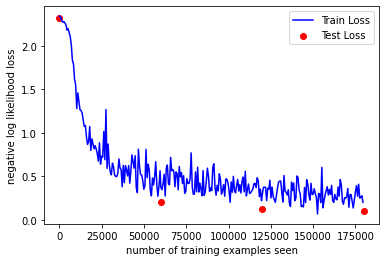

In [93]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses[:4], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [38]:
test_counter

[0, 60000, 120000, 180000]

In [39]:
test_losses

[2.308917578125,
 2.307491943359375,
 0.17562296905517577,
 0.09266644973754883,
 0.0787955825805664,
 0.06971725311279296,
 0.06971726264953614,
 0.06491416053771973,
 0.059481553268432616,
 0.05205410041809082]

In [42]:
with torch.no_grad():
  output = network(example_data)

d:\envs\pro\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


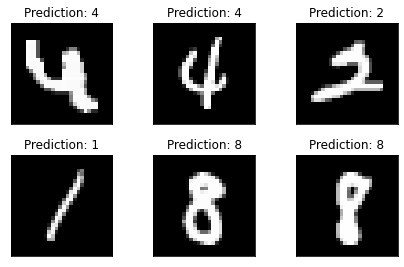

In [43]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])